 - When N and $\tau$ are different for all banks
     - can change the N and $\tau$ for each bank in the json file
 - with dynamic feed and configuration and formatting
     - if we want the feed to enter a different bank, we can just move that bank to the top
     - the 1's and 0's for that row (i.e. bank) won't change because the bank's outputs are still going to the same place

In [1]:
import numpy as np
import os, json
import pprint
import matplotlib.pyplot as plt
%matplotlib inline

pp = pprint.PrettyPrinter(indent=4)

with open("system_config.json", "r") as f:
    config_data = json.load(f)

### Questions/worries
- worried I don't have enough results

- some functions are dependant on other functions. Any idea how I could incoporate this in a flow diagram?

## Generate circuit configurations

In [2]:
def generate_type_config(condensed_config):
    type_config = []
    size = len(condensed_config)

    for i in range(0, size):
        row = []
        for j in range(0, size + 2):          
            if (j == condensed_config[i]):
                row.append(1)
            else:
                row.append(0)
        type_config.append(row)
    return np.array(type_config)

print(generate_type_config([1,3,4]))
print(len(generate_type_config([1,3,4])))

[[0 1 0 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]
3


In [3]:
def perm(indices):
    total = 1
    for bank_indices in indices:
        total *= len(bank_indices)
           
    return total


In [4]:
'''
    This function returns the indices that contain true (i.e. = 1) values for a given configuration.
'''
def get_circuit_indices(meta_circuit_config):
    circuit_indices = []
    for config_type in meta_circuit_config:
        type_indices = []
        for bank in config_type:
            bank_indices = []
            for i, output_flag in enumerate(bank):
                if (output_flag == 1): bank_indices.append(i)

            if bank_indices:
                type_indices.append(bank_indices)
            else:
                type_indices.append([-1])
        circuit_indices.append(type_indices)

    return circuit_indices

'''
    This function basically returns the number of possibilities/permutations for an array of indices.
    The indices in this case are not even necessarily all indices of a type (concentrate/tailings)
        array. They could also be just some of those indices. The idea is to have the total number of
        permutations for x indices.
'''
def perm(indices):
    total = 1
    for bank_indices in indices:
        total *= len(bank_indices)
           
    return total

'''
    This function takes a condensed configuration, such as [1, 3, 4], and generates the full 
        configuration matrix, such as:
        [
            [0, 1, 0, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1]
        ]

    Called it a "type config" because it is only a configuration matrix for a specific type, ie.
        concentrate or tailings
'''
def generate_type_config(condensed_config):
    type_config = []
    size = len(condensed_config)

    for i in range(0, size):
        row = []
        for j in range(0, size + 2):
            if (j == condensed_config[i]):
                row.append(1)
            else:
                row.append(0)
        type_config.append(row)
    return np.array(type_config)

meta_circuit_config = np.array(config_data["meta_config"])

size = len(meta_circuit_config[0][0]) - 2
circuit_indices = get_circuit_indices(meta_circuit_config)
condensed_configs = [[], []]
print(circuit_indices)

for i, type_indices in enumerate(circuit_indices):
    counter = 0
    counters = []
    for j in range(0, size):
        counters.append(0)

    while (counter < perm(type_indices)):
        # pick a config
        condensed_config = []
        for j in range(0, size):
            condensed_config.append(type_indices[j][counters[j]])
            
        condensed_configs[i].append(condensed_config)
        counter += 1

        # update counters
        for j in range(0, size):
            wrap = perm(type_indices[j + 1::])
            if (counter % wrap == 0):
                counters[j] = (counters[j] + 1) % len(type_indices[j])
        
num_banks = len(config_data["meta_config"][0][0]) - 2
final_condensed_configs = []
for i in condensed_configs[0]:
    for j in condensed_configs[1]:
        if np.count_nonzero(np.array(i) == num_banks) == 1 and np.count_nonzero(np.array(j) == num_banks+1) == 1:
            final_condensed_configs.append([i, j])

final_configs = []
for condensed_config in final_condensed_configs:
    final_configs.append(np.array([generate_type_config(condensed_config[0]), generate_type_config(condensed_config[1])]))
    
#print(f'Number of configurations: {len(final_configs)}')

CPf = 4
CPs = 3
CCf = 3
CCs = 1.5
PYf = 5.1
PYs = 3.7
SC = 250
GNG = 300

# feed = np.array([CPf, CPs, CCf, CCs, PYf, PYf, PYs, SC, GNG])
feed = np.array(config_data["feed"], dtype=np.double)

# -2 because p and w are not banks
num_banks = len(config_data["meta_config"][0][0]) - 2
num_components = len(feed)
print(num_components)

pp.pprint(len(final_configs))

[[[1, 2, 3, 5], [2, 3, 5], [3, 5], [5], [1, 2, 3, 5]], [[4, 6], [4, 6], [4, 6], [4, 6], [0, 6]]]
8
90


## Functions

In [5]:
def inlet_mass_frac(M_component):
    if (sum(M_component) == 0):
        return np.full(M_component.shape[0], 0)
    
    Mass_frac = M_component/sum(M_component)
    return Mass_frac

def kinetic_constant():                                 
    return np.array(config_data["k_const"])

def calculate_recoveries(N, τ, bank_input):
    recoveries = []
    Rmax_1 = inlet_mass_frac(bank_input)
    for kmax, Rmax, M_comp in zip(kinetic_constant(), Rmax_1, bank_input):
        recoveries.append(Rmax*(1-(1-(1+kmax*τ)**(1-N))/((N-1)*kmax*τ)))
    return recoveries

'''
    Calculates the inputs for a bank given a circuit configuration, the circuit values at that iteration and
        a bank index (row number; rows represent banks in the config matrix)
'''
def calculate_bank_inputs(bank_index, circuit_config, circuit_values):
    num_banks = circuit_config.shape[1]
    concentrate_col = circuit_config[0][:, bank_index]
    tailings_col = circuit_config[1][:, bank_index]
    bank_inputs = np.zeros((num_components), dtype=np.double)
    for i in range(0, num_banks):
        if (concentrate_col[i] == 1):
            bank_inputs += circuit_values[i][0]
        if (tailings_col[i] == 1):
            bank_inputs += circuit_values[i][1]
            
    return bank_inputs

def bank(N, τ, bank_input):
    array_conc_out_bank = []
    array_tail_out_bank = []
    for i, R in enumerate(calculate_recoveries(N, τ, bank_input)):
        M_comp = bank_input[i]
        Mconc = M_comp*R
        Mtail = M_comp*(1-R)
        array_conc_out_bank.append(Mconc)
        array_tail_out_bank.append(Mtail)        
    
    return array_conc_out_bank, array_tail_out_bank

## Solve steady-state mass balance

In [6]:
def errf(bank_recoveries):
    total = 0
    num_banks = bank_recoveries.shape[1]
    for i in range(0, num_banks):
        for j in range(0, num_components):
            total += ( (bank_recoveries[0][i][j] - bank_recoveries[1][i][j]) ** 2 ) / (bank_recoveries[0][i][j] ** 2)
    
    return total

def get_output_banks(config):
    product = np.where(config[0][:,-2] == 1)[0]
    waste = np.where(config[1][:,-1] == 1)[0]
    return product, waste
    

crec = np.zeros((len(final_configs), num_components))
trec = np.zeros((len(final_configs), num_components))
cgrades = np.zeros((len(final_configs), num_components))
tgrades = np.zeros((len(final_configs), num_components))

for k, circuit_config in enumerate(final_configs):
    counter = 1
    bank_recoveries = np.zeros((2, num_banks, num_components))
    circuit_values = np.zeros((num_banks, 2, num_components), dtype=np.double)

    while (counter <= 2 or errf(bank_recoveries) > 0.00001):
        '''
            new_circuit_values is updated continuously and is eventually used to update circuit_values, which can
                only be updated after all banks have been calculated for the iteration as we do not want
                sequence/dependence to play a role.
        '''
        new_circuit_values = np.zeros((num_banks, 2, num_components), dtype=np.double)

        for i in range(0, num_banks):
            N, τ = config_data["banks"][i]
            # determine inputs from other banks
            bank_inputs = calculate_bank_inputs(i, circuit_config, circuit_values)

            # for the first iteration, we are working with the bank that receives an extra input, namely feed
            if (i == 0):
                new_circuit_values[i] = bank(N, τ, feed + bank_inputs)
            else:
                new_circuit_values[i] = bank(N, τ, bank_inputs)

        circuit_values = new_circuit_values
       
        # update bank recoveries
        bank_recoveries[1] = bank_recoveries[0]
        for i in range(0, num_banks):
            N, τ = config_data["banks"][i]
            bank_inputs = calculate_bank_inputs(i, circuit_config, circuit_values)
            bank_recoveries[0][i] = calculate_recoveries(N, τ, bank_inputs)

        counter += 1
        
    # calculate and store grades and recoveries
    product_bank_index, waste_bank_index = get_output_banks(circuit_config)
    for l in range(0, num_components):
        crec[k][l] = circuit_values[product_bank_index, 0][0][l] / feed[l]
        trec[k][l] = circuit_values[waste_bank_index, 1][0][l] / feed[l]
    
        cgrades[k][l] = circuit_values[product_bank_index, 0][0][l] / np.sum(circuit_values[product_bank_index, 0][0])
        tgrades[k][l] = circuit_values[waste_bank_index, 1][0][l] / np.sum(circuit_values[waste_bank_index, 1][0])

    if (counter == 3): continue

    print("Iterations required to reach steady state: {}\n".format(counter))
    print("\t\t", end="")
    for i in range(0, num_components):
        print("\tComponent{}\t".format(i+1), end="")
    print("\n")
    for i in range(0, num_banks):
        concentrate = "\t".join(["{:f}".format(i) for i in circuit_values[i][0]])
        tailings = "\t".join(["{:f}".format(i) for i in circuit_values[i][1]])
        print("Concentrate:\t{}\nTailings:\t{}\tBank{}\n".format(concentrate, tailings, i+1))
    
    print("\nCircuit configuration")
    print("Concentrate\t\t\tTailings\n")
    for i in range(0, num_banks):
        conc = "  ".join(["{:d}".format(k) for k in circuit_config[0][i]])
        tail = "  ".join(["{:d}".format(k) for k in circuit_config[1][i]])
        print("{}\t\t{}".format(conc, tail))
            
    
    print("\n\n")
    



C:\Anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in double_scalars


Iterations required to reach steady state: 238

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	4.402850	3.201016	3.103879	1.789451	5.283198	4.751197	261.441435	290.687476
Tailings:	140.039838	87.779440	85.367330	71.805002	110.036522	118.356349	582.291176	576.309067	Bank1

Concentrate:	0.019795	0.016636	0.015922	0.004644	0.046195	0.031547	107.060300	137.241520
Tailings:	4.379436	3.183802	3.087440	1.783261	5.236516	4.718508	154.378874	153.444399	Bank2

Concentrate:	0.000001	0.000001	0.000001	0.000000	0.000008	0.000004	44.100026	73.998922
Tailings:	0.019761	0.016629	0.015915	0.004636	0.046178	0.031529	62.960608	63.243947	Bank3

Concentrate:	0.009772	0.014795	0.015000	0.003150	0.043716	0.020148	101.955322	150.600457
Tailings:	2.850194	2.957640	2.959464	1.422694	5.031856	3.634710	147.938954	149.294603	Bank4

Concentrate:	2.862343	2.972962	2.974950	1.427090	5.076009	3.655728	205.796131	225.898005
Tailings:	141.509083	87.993549

Iterations required to reach steady state: 260

			Component1		Component2		Component3		Component4		Component5		Component6		Component7		Component8	

Concentrate:	4.714650	3.452949	3.348751	1.914165	5.719167	5.123938	330.485383	354.954083
Tailings:	158.757506	99.892126	97.154819	81.332213	125.504448	134.698080	707.005337	692.851626	Bank1

Concentrate:	0.007609	0.013249	0.013509	0.002680	0.039677	0.017235	121.949073	149.197590
Tailings:	2.841622	2.970421	2.972761	1.416284	5.074917	3.650512	169.541156	167.423948	Bank2

Concentrate:	0.016409	0.011758	0.011178	0.003368	0.032822	0.023731	196.251338	248.822990
Tailings:	4.701926	3.453847	3.350555	1.911806	5.725565	5.116231	256.180974	255.326415	Bank3

Concentrate:	0.000000	0.000000	0.000000	0.000000	0.000002	0.000001	80.337433	132.453828
Tailings:	0.016381	0.011754	0.011174	0.003362	0.032815	0.023719	115.914615	116.370185	Bank4

Concentrate:	2.851641	2.984196	2.986752	1.420223	5.115016	3.668634	291.491825	316.624057
Tailings:	160.547544	100.35

In [7]:
print(len(cgrades))

90


## Sorted based on grade

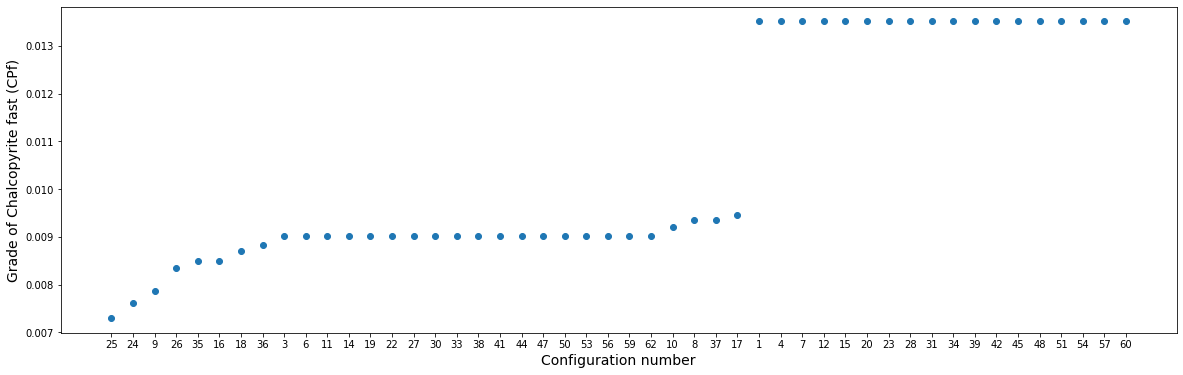

In [11]:
Cgrades_c1_unsorted = [x for x in tgrades[:,1] if np.isnan(x) == False]

list_configs = [i for i in range(1, len(final_configs) + 1)]
Cgrades_c1, list_configs_sorted = [list(v) for v in zip(*sorted(zip(Cgrades_c1_unsorted,list_configs)))]
list_configs_sorted_string = [str(x) for x in list_configs_sorted]

Cgrades_c1_sufficient = []
config_number_sufficient = []

for a, i in enumerate(Cgrades_c1):
    if i > 0.002:
        Cgrades_c1_sufficient.append(i)
        config_number_sufficient.append(list_configs_sorted_string[a])

plt.figure(figsize=(20, 6))
plt.plot(config_number_sufficient, Cgrades_c1_sufficient, 'o')
plt.xlabel('Configuration number', fontsize=14)
plt.ylabel('Grade of Chalcopyrite fast (CPf)', fontsize=14)
plt.savefig("Grade vs config number.jpg", bbox_inches='tight')
# plt.xlim(40, 120)
plt.show()

## Sorted based on recovery

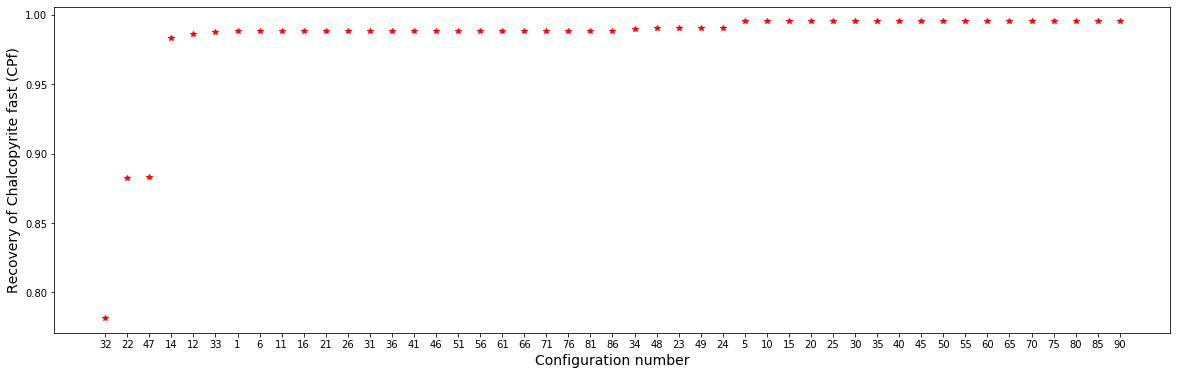

In [12]:
Crec_c1_unsorted = [x for x in trec[:,1] if np.isnan(x) == False]

list_configs = [i for i in range(1, len(final_configs) + 1)]
Crecs_c1, list_configs_sorted = [list(v) for v in zip(*sorted(zip(Crec_c1_unsorted,list_configs)))]
list_configs_sorted_string = [str(x) for x in list_configs_sorted]

Crecs_c1_sufficient = []
config_number_sufficient = []

for a, i in enumerate(Crecs_c1):
    if i > 0.5:
        Crecs_c1_sufficient.append(i)
        config_number_sufficient.append(list_configs_sorted_string[a])

# plt.figure(figsize=(20, 6))
# plt.plot(config_number_sufficient, Crecs_c1_sufficient,'*', color='r')
# plt.xlabel('Configuration number')
# plt.ylabel('Recovery')
# plt.xlim(15, 60)
# plt.savefig("Recovery vs config number.jpg")
# plt.show()

plt.figure(figsize=(20, 6))
plt.plot(config_number_sufficient, Crecs_c1_sufficient,'*', color='r')
plt.xlabel('Configuration number', fontsize=14)
plt.ylabel('Recovery of Chalcopyrite fast (CPf)', fontsize=14)
# plt.xlim(40, 90)
plt.savefig("Recovery vs config number.jpg", bbox_inches='tight')
plt.show()

# Objective function

#### Calculate Vcell from $\tau$

$\tau$ = $\frac{Vcell\cdot\rho}{Feed}$

In [10]:
N = np.array(config_data["banks"])[:,0]
τ = np.array(config_data["banks"])[:,1]
feed = np.array(config_data["feed"])
ρfeed = np.array([1000, 1000, 1000, 1000])

Vcell_per_bank = τ*feed/ρfeed*N
print(f'Volume of cells per bank = {Vcell_per_bank}')

ValueError: operands could not be broadcast together with shapes (5,) (8,) 

In [ ]:
def Capital_cost():
    FL = 3
    FLw = 0.9
    Ifi = 105.7 + 10.72*sum(Vcell_per_bank) - 149.1*sum(Vcell_per_bank)**2
    
    If = FL*Ifi
    Iw = FLw*Ifi
    
    return If, Iw

If = Capital_cost()[0]
Iw = Capital_cost()[1]

print(f'Fixed capital (If) = {If}')
print(f'Wokring capital (Iw) = {Iw}')

In [ ]:
def Revenue():
    p = 0.975
    µ = 0.015
    Trc = 0.15
    Rfc = 0.3
    H = 7200
    q = 8
    
    Revenue = (p*(max(Cgrades_c1)-µ)*(q-Rfc) - Trc)*H
    
    return Revenue

Revenue = Revenue()
print(f'Revenue = {Revenue}')

In [ ]:
Vi_list = np.linspace(1, 15)
Ifi_list = (105.7 + 10.72*Vi_list + 149.1*Vi_list**2)#/Vi_list

plt.plot(Vi_list, Ifi_list)

In [ ]:
Vi = 0.1
Ifi_list = 105.7 + 10.72*Vi - 149.1*Vi**2

print(Ifi_list)